In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 260 (delta 61), reused 49 (delta 49), pack-reused 163
Receiving objects: 100% (260/260), 53.29 MiB | 28.25 MiB/s, done.
Resolving deltas: 100% (118/118), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=22409 sha256=9150d6a1b5d033baff6c93f682e25273a55c03958f8142af6cf82011dd991a45
  Stored in directory: /tmp/pip-ephem-wheel-cache-9q0gxehf/wheels/55/59/29/0fb1c635652157734

In [2]:
from dul_2021.utils.hw7_utils import *

In [3]:
from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import matplotlib.pyplot as plt
import torch.optim as opt
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from torch.distributions.beta import Beta

import copy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from scipy.stats import norm
from scipy.optimize import bisect
from tqdm import trange, tqdm_notebook
from torch.utils import data
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1: GANs on CIFAR-10

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


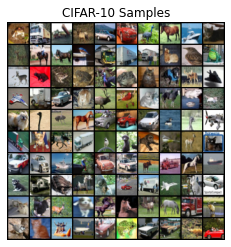

In [4]:
visualize_q1_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Discriminator loss across training
3. 100 samples. 

## Solution

In [5]:
class SpaceToDepth(nn.Module):
    # [64, 3, 224, 224] --> [64, 12, 112, 112]
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2) # ([64, 3, 2, 224], ..., [64, 3, 2, 224])
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output


class DepthToSpace(nn.Module):
    # [64, 12, 112, 112] --> [64, 3, 224, 224]
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


# Spatial Downsampling with Spatial Mean Pooling
class Downsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.s2d = SpaceToDepth(block_size=2)
        self.conv = nn.Conv2d(in_channels=in_dim, out_channels=out_dim, 
                              kernel_size=kernel_size, stride=stride,
                              padding=padding)

    def forward(self, x):
        out = self.s2d(x)
        out = out.chunk(4, dim=1)
        out = torch.mean(torch.stack(out, dim=4), dim=4)
        out = self.conv(out)
        return out



# Spatial Upsampling with Nearest Neighbors'=
class Upsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.d2s = DepthToSpace(block_size=2)
        self.conv = nn.Conv2d(in_channels=in_dim, out_channels=out_dim, 
                              kernel_size=kernel_size, stride=stride,
                              padding=padding)

    def forward(self, x):
        out = torch.cat([x, x, x, x], dim=1)
        out = self.d2s(out)
        out = self.conv(out)
        return out

In [6]:
class ResnetBlockDown(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super().__init__()
        self.conv = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)
        self.downsample_residual = Downsample_Conv2d(n_filters, n_filters, 
                                                     kernel_size, padding=1)
        self.downsample_shortcut = Downsample_Conv2d(in_dim, n_filters, 
                                                     kernel_size=(1, 1), padding=0)

    def forward(self, x):
        shortcut = self.downsample_shortcut(x)

        out = self.conv(F.relu(x))
        out = F.relu(out)
        residual = self.downsample_residual(out)
        return residual + shortcut


class ResnetBlockUp(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_dim)
        self.bn2 = nn.BatchNorm2d(n_filters)

        self.conv = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)
        self.upsample_residual = Upsample_Conv2d(n_filters, n_filters, 
                                                 kernel_size, padding=1)
        self.upsample_shortcut = Upsample_Conv2d(in_dim, n_filters,
                                                 kernel_size=(1, 1), padding=0)

    def forward(self, x):
        shortcut = self.upsample_shortcut(x)

        out = self.bn1(x)
        out = self.conv(F.relu(out))
        out = F.relu(self.bn2(out))
        residual = self.upsample_residual(out)
        return residual + shortcut

In [7]:
from torch.distributions.normal import Normal

class Generator(nn.Module):
    def __init__(self, n_filters=128):
        super().__init__()
        self.linear = nn.Linear(128, 4 * 4 * 256)
        self.block_up_1 = ResnetBlockUp(in_dim=256, n_filters=n_filters)
        self.block_up_2 = ResnetBlockUp(in_dim=n_filters, n_filters=n_filters)
        self.block_up_3 = ResnetBlockUp(in_dim=n_filters, n_filters=n_filters)
        self.bn = nn.BatchNorm2d(n_filters)
        self.conv = nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1)

        self.lat_distr = Normal(torch.tensor([0.0]).to(device),
                                torch.tensor([1.0]).to(device))

    def sample(self, n_samples=1024):
        z = self.lat_distr.sample([n_samples, 128]).squeeze()
        x = self.linear(z)
        x = x.reshape(-1, 256, 4, 4)
        x = self.block_up_1(x)
        x = self.block_up_2(x)
        x = self.block_up_3(x)
        x = F.relu(self.bn(x))
        x = self.conv(x)
        x = torch.tanh(x)
        return x


class Discriminator(nn.Module):
    # Critic
    def __init__(self, n_filters=128):
        super().__init__()
        # self.linear = nn.Linear(128, 4 * 4 * 256)
        self.block_down_1 = ResnetBlockDown(in_dim=3, n_filters=n_filters)
        self.block_down_2 = ResnetBlockDown(in_dim=n_filters, n_filters=n_filters)
        self.block_down_3 = ResnetBlockDown(in_dim=n_filters, n_filters=n_filters)
        
        # self.conv = nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1)
        self.linear = nn.Linear(4 * 4 * 128, 1)


    def forward(self, x):
        bs = x.shape[0]
        # x = self.linear(z)
        
        x = self.block_down_1(x)
        x = self.block_down_2(x)
        x = self.block_down_3(x)
        x = F.relu(x)
        x = x.reshape(-1, 128 * 4 * 4)

        # x = self.conv(x)
        # x = torch.tanh(x)
        x = self.linear(x)
        # x = x.sigmoid()
        return x

In [8]:
class WGAN_GP(nn.Module):
    def __init__(self, latent_dim=128, lam=10):
        super().__init__()
        self.latent_dim = latent_dim
        self.generator = Generator()
        self.discriminator = Discriminator()
        self.lam = lam

    def get_GP(self, real, fake):
        bs = real.shape[0]
        eps = torch.rand(bs, 1, 1, 1).to(device)
        x = eps * real + (1 - eps) * fake
        x.requires_grad_()
        output = self.discriminator(x)

        dD = torch.autograd.grad(outputs=output,
                                 inputs=x,
                                 grad_outputs=torch.ones(output.size()).to(device),
                                 retain_graph=True,
                                 create_graph=True,)[0] # only_inputs=True

        # penalize gradients
        dD = dD.reshape(bs, -1)
        GP = torch.mean(torch.norm(dD, dim=1) - 1) ** 2
        return GP



    def dis_loss(self, real):
        fake = self.generator.sample(real.shape[0]).float()

        loss = -self.discriminator(real) + self.discriminator(fake)

        # gradient penalty
        GP = self.get_GP(real, fake)
        loss += self.lam * GP

        return loss.mean()

    def gen_loss(self, real):
        fake = self.generator.sample(real.shape[0]).float()
        loss = -self.discriminator(fake)
        return loss.mean()

    def fit(self, train_data, n_critic=5, lr=1e-3, num_epochs=100, 
            bs=128, betas=(0.9, 0.999)):
        trainloader = data.DataLoader(train_data,
                                      batch_size=bs, 
                                      shuffle=True)
        
        # testloader = torch.utils.data.DataLoader(test_data, 
        #                                          batch_size=bs)

        gen_opt = opt.Adam(self.generator.parameters(), lr=lr, betas=betas)
        gen_sch = torch.optim.lr_scheduler.LinearLR(gen_opt)
        dis_opt = opt.Adam(self.discriminator.parameters(), lr=lr, betas=betas)
        dis_sch = torch.optim.lr_scheduler.LinearLR(dis_opt)

        
        train_loss = []

        for epoch in tqdm(range(num_epochs)):
            t_losses = []
            for i, r_batch in enumerate(trainloader):
                # в батче будет только картинка, без класса?
                r_batch = r_batch.float().to(device)

                
                # обновляем дискриминатор
                loss = self.dis_loss(r_batch)
                dis_opt.zero_grad()
                loss.backward()
                dis_opt.step()
                    
                cur_loss = loss.item()
                train_loss.append(cur_loss)
                t_losses.append(cur_loss)

                if i % n_critic == 0:
                    # обновляем генератор на каждом n_critic-м шаге
                    loss = self.gen_loss(r_batch)
                    gen_opt.zero_grad()
                    loss.backward()
                    gen_opt.step()

                    gen_sch.step()
                    dis_sch.step()
                    

            print(f'Epoch {epoch + 1}: d_loss= {np.mean(t_losses):.5f}')

        return np.array(train_loss)


    def sample(self, n=100):
        with torch.no_grad():
            samples = self.generator.sample(n_samples=n)
            samples = torch.clip(samples, -1, 1)
        return samples.cpu().detach().numpy()

In [9]:
def q1(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """

    train_data = train_data * 2 - 1
    gan = WGAN_GP()
    gan.to(device)
    train_loss = gan.fit(train_data, bs=256, lr=2e-4, betas=(0, 0.9), num_epochs=5)
    samples = gan.sample(1000).transpose(0, 2, 3, 1)
    samples = (samples + 1) / 2  # (1000, 32, 32, 3)

    return train_loss, samples

## Results

Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: d_loss= -3.46320
..........Inception score: 2.109389


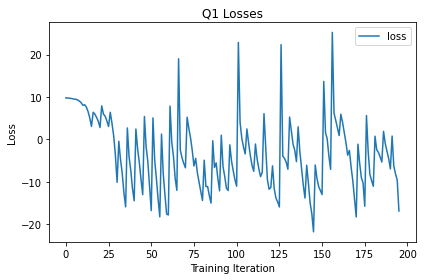

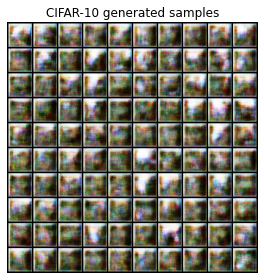

In [ ]:
q1_save_results(q1) # 1 ep == 9 min

Files already downloaded and verified


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: d_loss= -2.42256
Epoch 2: d_loss= -3.13835
Epoch 3: d_loss= -2.44572
Epoch 4: d_loss= -2.03342
Epoch 5: d_loss= -1.90644
..........Inception score: 2.3551269


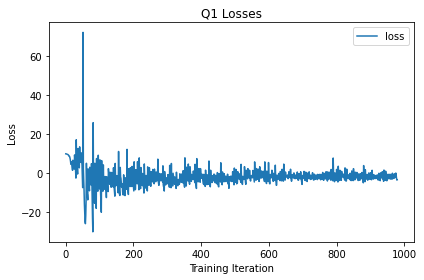

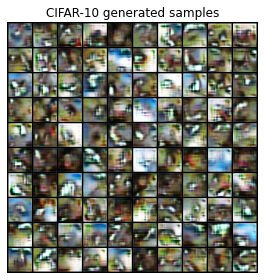

In [10]:
q1_save_results(q1) # 5 ep == 5 * 9 min

Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: d_loss= -4.33746
Epoch 2: d_loss= -3.29260
Epoch 3: d_loss= -2.83492
Epoch 4: d_loss= -2.54989
Epoch 5: d_loss= -1.83079
Epoch 6: d_loss= -1.49311
Epoch 7: d_loss= -1.23600
Epoch 8: d_loss= -1.40109
Epoch 9: d_loss= -1.26009
Epoch 10: d_loss= -1.17803
..........Inception score: 4.0736127


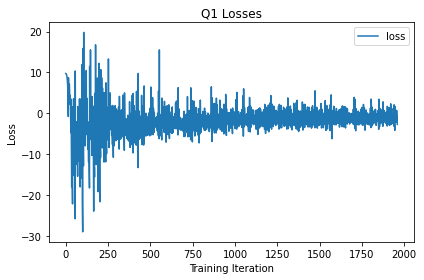

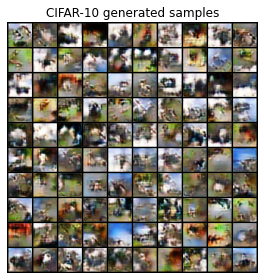

In [ ]:
q1_save_results(q1) # 10 ep == 10 * 9 min

Files already downloaded and verified



..........Inception score: 6.062043


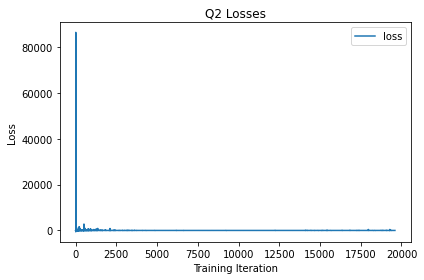

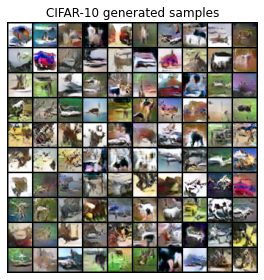

In [ ]:
q1_save_results(q1) # ref

# Question 2: Representation Learning with BiGAN on MNIST

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


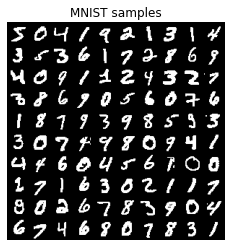

In [ ]:
visualize_q2_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


## Solution

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, latent_dim=50, hidden_dim=1024):
        super().__init__()
        self.in_layer = nn.Linear(28 * 28 + latent_dim, hidden_dim)
        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        self.out_layer = nn.Linear(hidden_dim, 1)
        self.bn = nn.BatchNorm1d(hidden_dim, affine=False)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        self.sigma = nn.Sigmoid()

    def forward(self, x, z):
        x = x.reshape(x.shape[0], -1)
        out = torch.cat([x, z], dim=1)
        out = self.in_layer(out)
        out = self.leaky_relu(out)
        out = self.hidden_layer(out)
        out = self.leaky_relu(self.bn(out))
        out = self.out_layer(out)
        out = self.sigma(out)
        return out


class Encoder(nn.Module):
    def __init__(self, latent_dim=50, hidden_dim=1024):
        super().__init__()
        self.in_layer = nn.Linear(28 * 28, hidden_dim)
        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        self.out_layer = nn.Linear(hidden_dim, latent_dim)

        self.bn = nn.BatchNorm1d(hidden_dim, affine=False)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        z = self.in_layer(x)
        z = self.leaky_relu(z)
        z = self.hidden_layer(z)
        z = self.leaky_relu(self.bn(z))
        z = self.out_layer(z)
        return z


class Generator(nn.Module):
    def __init__(self, latent_dim=50, hidden_dim=1024):
        super().__init__()
        self.in_layer = nn.Linear(latent_dim, hidden_dim)
        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        self.out_layer = nn.Linear(hidden_dim, 28 * 28)

        self.bn = nn.BatchNorm1d(hidden_dim, affine=False)
        self.relu = nn.ReLU()

    def forward(self, z):
        x = self.in_layer(z)
        x = self.relu(x)
        x = self.hidden_layer(x)
        x = self.relu(self.bn(x))
        x = self.out_layer(x)
        return torch.tanh(x).view(x.shape[0], 28, 28, 1)


class Classifier(nn.Module):
    def __init__(self, latent_dim=50, class_num=10):
        super().__init__()
        self.layer = nn.Linear(latent_dim, class_num)

    def forward(self, z):
        out = self.layer(z)
        return out


    def nll(self, y_hat, y):
        return F.cross_entropy(y_hat, y.long())

    def test(self, testloader, encoder):
        loss = 0
        t = 0
        with torch.no_grad():
            for batch in testloader:
                batch, classes = batch
                batch = batch.to(device)
                classes = classes.to(device)
                outputs = self(encoder(batch))
                loss = self.nll(outputs, classes)
                loss += loss * batch.shape[0]
                t += batch.shape[0]

        return loss.item() / t

    def fit(self, train_data, test_data, encoder, lr=1e-3, num_epochs=100, 
            bs=128, betas=(0.9, 0.999)):
        trainloader = data.DataLoader(train_data,
                                      batch_size=bs, 
                                      shuffle=True)
        
        testloader = data.DataLoader(test_data,
                                     batch_size=bs, 
                                     shuffle=False)

        optim = opt.Adam(self.parameters(), lr=1e-3)
        
        test_losses = [self.test(testloader, encoder)]
        for epoch in tqdm(range(num_epochs)):
            train_losses = []
            for batch in trainloader:
                batch, classes = batch
                batch = batch.to(device)
                classes = classes.to(device)

                # обновляем классификатор
                outputs = self(encoder(batch))
                loss = self.nll(outputs, classes)
                optim.zero_grad()
                loss.backward()
                optim.step()

                cur_loss = loss.item()
                train_losses.append(cur_loss)


            print(f'Epoch {epoch + 1}: cl_loss= {np.mean(train_losses):.5f}')
            test_losses.append(self.test(testloader, encoder))

        return np.array(test_losses)

In [ ]:
class BigGAN(nn.Module):
    def __init__(self, latent_dim=50, hidden_dim=1024):
        super().__init__()
        self.latent_dim = latent_dim
        self.D = Discriminator(latent_dim=latent_dim,
                               hidden_dim=hidden_dim)
        self.E = Encoder(latent_dim=latent_dim, 
                         hidden_dim=hidden_dim)
        self.G = Generator(latent_dim=latent_dim, 
                           hidden_dim=hidden_dim)

        self.lat_distr = Normal(torch.tensor([0.0]).to(device),
                                torch.tensor([1.0]).to(device))



    def dis_loss(self, real):
        z_real = self.E(real)
        z_fake, fake = self.sample(real.shape[0])
        loss = -self.D(real, z_real).log() - (1 - self.D(fake, z_fake)).log()
        return loss.mean()

    def gen_loss(self, real):
        z_real = self.E(real)
        z_fake, fake = self.sample(real.shape[0])
        # loss = (1 - self.D(fake, z_fake)).log()
        loss = self.D(real, z_real).log() + (1 - self.D(fake, z_fake)).log()
        return loss.mean()


    def fit(self, train_data, lr=2e-4, num_epochs=100, 
            bs=128, betas=(0.5, 0.999)):
        trainloader = data.DataLoader(train_data,
                                      batch_size=bs, 
                                      shuffle=True)

        dis_opt = opt.Adam(self.D.parameters(), lr=lr, betas=betas, weight_decay=2.5e-5)
        dis_sch = torch.optim.lr_scheduler.LinearLR(dis_opt)

        gen_opt = opt.Adam([{'params': self.G.parameters()},
                            {'params': self.E.parameters()}], 
                            lr=lr, betas=betas, weight_decay=2.5e-5)
        gen_sch = torch.optim.lr_scheduler.LinearLR(gen_opt)

        
        train_D_loss = []

        for epoch in tqdm(range(num_epochs)):
            t_losses = []
            for r_batch in trainloader:
                
                r_batch = r_batch.float().to(device)

                # обновляем дискриминатор
                loss = self.dis_loss(r_batch)
                dis_opt.zero_grad()
                loss.backward()
                dis_opt.step()

                cur_loss = loss.item()
                train_D_loss.append(cur_loss)
                t_losses.append(cur_loss)
                    
                # обновляем генератор
                loss = self.gen_loss(r_batch)
                gen_opt.zero_grad()
                loss.backward()
                gen_opt.step()

            print(f'Epoch {epoch + 1}: d_loss= {np.mean(t_losses):.5f}')
            
            dis_sch.step()
            gen_sch.step()

        return np.array(train_D_loss)



    def reconstruct(self, x):
        with torch.no_grad():
            z = self.E(x)
            x_rec = self.G(z)
            x_rec = torch.clip(x_rec, -1, 1)
        return x_rec


    def sample(self, n=100):
        z = self.lat_distr.sample([n, self.latent_dim]).squeeze()
        samples = self.G(z)
        samples = torch.clip(samples, -1, 1)
        return z, samples

In [ ]:
def q2(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
    """

    # train gan
    gan = BigGAN()
    gan.to(device)
    train_losses = gan.fit(train_data.data, num_epochs=4)

    # samples
    _, samples = gan.sample(100)
    samples = ((samples + 1) / 2).detach().cpu().numpy()

    # reconstructions
    x = train_data.data[:20].float()
    x_ = (x / 255) * 2 - 1
    x_rec_ = gan.reconstruct(x_.to(device))
    x_rec = ((x_rec_ + 1) / 2).detach().cpu().numpy()
    x_ = ((x_ + 1) / 2).cpu().numpy()[:, :, :, None]
    reconstructions = np.concatenate([x_, x_rec], axis=0)

    # linear classifier with E
    E = gan.E
    E.eval()
    classifier_1 = Classifier()
    classifier_1.to(device)
    classifier_1.train()
    test_losses_1 = classifier_1.fit(train_data, test_data,
                                     num_epochs=5, encoder=E)

    # linear classifier with E_random
    E_rand = Encoder()
    E_rand.to(device)
    E_rand.eval()
    classifier_2 = Classifier()
    classifier_2.to(device)
    classifier_2.train()
    test_losses_2 = classifier_2.fit(train_data, test_data,
                                     num_epochs=5, encoder=E_rand)

    return train_losses, samples, reconstructions, test_losses_1, test_losses_2

## Results

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: d_loss= 1.01032
Epoch 2: d_loss= 0.47325
Epoch 3: d_loss= 0.26800
Epoch 4: d_loss= 0.16627


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: cl_loss= 3.09091
Epoch 2: cl_loss= 2.32034
Epoch 3: cl_loss= 2.28809
Epoch 4: cl_loss= 2.26693
Epoch 5: cl_loss= 2.24597


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: cl_loss= 2.19767
Epoch 2: cl_loss= 2.00770
Epoch 3: cl_loss= 1.84673
Epoch 4: cl_loss= 1.70997
Epoch 5: cl_loss= 1.59377


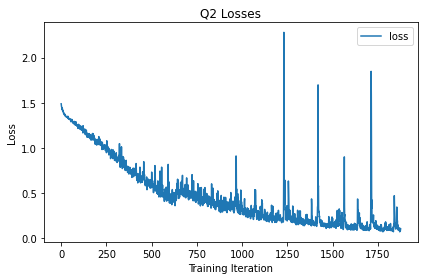

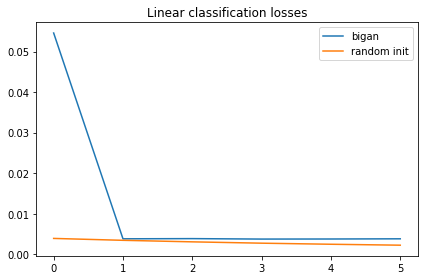

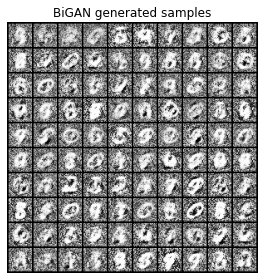

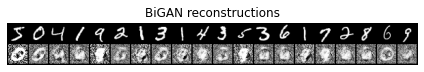

BiGAN final linear classification loss: 0.00384542350769043
Random encoder linear classification loss: 0.002272266387939453


In [ ]:
q2_save_results(q2)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: d_loss= 0.94381
Epoch 2: d_loss= 0.41949
Epoch 3: d_loss= 0.24966
Epoch 4: d_loss= 0.16477
Epoch 5: d_loss= nan
Epoch 6: d_loss= nan
Epoch 7: d_loss= nan
Epoch 8: d_loss= nan
Epoch 9: d_loss= nan
Epoch 10: d_loss= nan


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: cl_loss= nan
Epoch 2: cl_loss= nan
Epoch 3: cl_loss= nan
Epoch 4: cl_loss= nan
Epoch 5: cl_loss= nan


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: cl_loss= 2.17987
Epoch 2: cl_loss= 1.96945
Epoch 3: cl_loss= 1.79532
Epoch 4: cl_loss= 1.65103
Epoch 5: cl_loss= 1.53068


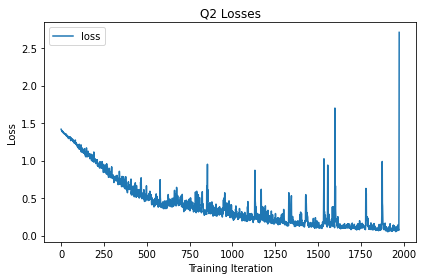

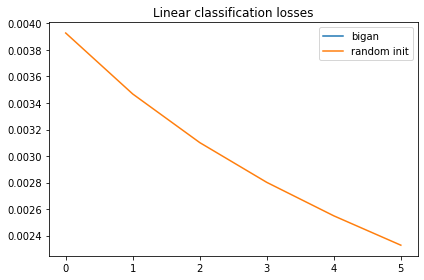

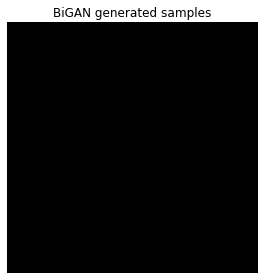

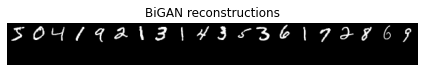

BiGAN final linear classification loss: nan
Random encoder linear classification loss: 0.002328217124938965


In [ ]:
# если дольше обучать ган, то в лоссе будут наны
q2_save_results(q2)

# Bonus 5: CycleGAN
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

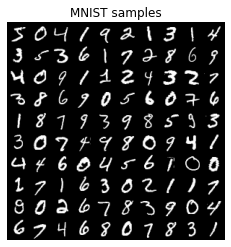

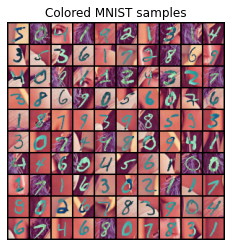

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [ ]:
def b5(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

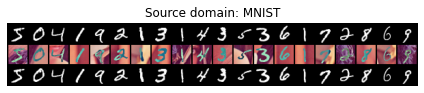

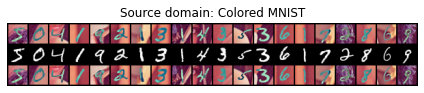

In [ ]:
b5_save_results(b5)